In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd
import seaborn as sns

#sns.set_style('darkgrid')

In [2]:
def plot_frame(frame):
    times = [i for i in range(1024)]

    plt.figure(figsize=(15, 10))

    for channel_id in range(128):
        plt.plot(times, frame[:, channel_id].flatten())

    plt.grid(True)
    plt.legend()
    plt.show()

# Loading

In [3]:
from calendar import c


def load_exps_and_labels(detections):
    all_exps, all_labels = [], []

    counter = 0

    for exp_name, data in detections.groupby('Exp'):
        counter += 1

        try:
            file = h5py.File(f'../../data/real/{exp_name}.h5', 'r')
        except:
            print(f'Couldnt load exp {exp_name}')
            continue

        exp = []
        
        channel = file[f'Chn{8}']
        exp = channel

        chirps_ids = []

        for _, (frame_id, depth) in data[['Frame', 'Depth']].iterrows():
            chirps_ids = list(np.linspace(frame_id*127, frame_id*128+127, 128, dtype=np.uint16))
            all_labels.append(list(np.repeat(depth, 128)))
            all_exps.append(exp[chirps_ids])

        #if counter > 2:
        #    break
    
    all_exps = np.array(all_exps)
    all_labels = np.array([all_labels]).T
    #all_exps = np.swapaxes(all_exps, 1, 0)
    all_exps[:, :, :50] = 0
    
    return all_exps.astype(np.float32), all_labels.astype(np.float32)
        

In [4]:
FILE_NAME = 'EXP_17_all'

In [5]:
all_detections = pd.read_csv('../../data/real/TABULAR_CSV_ALL_CLASSES.csv')

In [6]:
detections = all_detections[all_detections['Exp'].str.contains('EXP_17_')].query('Class == "Motorcycle" and Depth <= 25')

In [7]:
pd.unique(detections['Exp'])

array(['EXP_17_C', 'EXP_17_D', 'EXP_17_E', 'EXP_17_F', 'EXP_17_S',
       'EXP_17_T', 'EXP_17_L', 'EXP_17_B', 'EXP_17_I', 'EXP_17_O',
       'EXP_17_G', 'EXP_17_M', 'EXP_17_P', 'EXP_17_R', 'EXP_17_H',
       'EXP_17_Q'], dtype=object)

In [8]:
#raw_data = load_exps([f'../../data/real/{FILE_NAME}.h5'])
raw_data, labels = load_exps_and_labels(detections)

In [9]:
labels.shape

(128, 790, 1)

In [10]:
raw_data = np.expand_dims(raw_data, axis=3)
raw_data.shape

(790, 128, 1024, 1)

In [11]:
np.save(f'../../data/preprocessed/{FILE_NAME}_sequentialone2.npy', raw_data)

In [12]:
raw_data.shape

(790, 128, 1024, 1)

# Scale

## Data Scale

In [13]:
data_min = raw_data.min()
data_max = raw_data.max()

In [14]:
print(f'Min: {data_min}, Max: {data_max}')

Min: -2444.0, Max: 2544.0


In [15]:
a, b = -1, 1

In [16]:
np.subtract(raw_data, data_min, out=raw_data)
np.multiply(raw_data, (b - a), out=raw_data)
np.divide(raw_data, (data_max - data_min), out=raw_data)
raw_data = np.add(raw_data, a, out=raw_data)

## Label Scale

### Label Generator Scale

In [17]:
labels_mean = labels.mean()
labels_std = labels.std()

In [18]:
print(f'Mean: {labels_mean}, Std: {labels_std}')

Mean: 12.902271270751953, Std: 6.502640724182129


In [19]:
labels_generator = (labels - labels_mean) / labels_std

### Label Discriminator Scale

In [20]:
labels_min = labels.min()
labels_max = labels.max()

In [21]:
labels_discriminator = a + ((labels - labels_min)*(b-a)) / (labels_max - labels_min)

# Save

In [22]:
np.save(f'../../data/preprocessed/{FILE_NAME}_sequentialone2_scaled.npy', raw_data)
np.save(f'../../data/preprocessed/{FILE_NAME}_sequentialone2_labels.npy', (labels_generator, labels_discriminator))

# Plots

In [24]:
raw_data.mean()

0.05235101

/home/eduardo/anaconda3/envs/rota2030/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


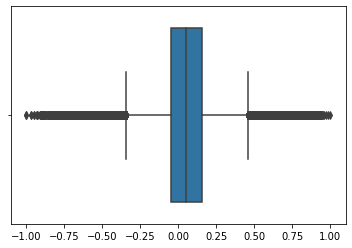

<Figure size 720x720 with 0 Axes>

In [23]:
import seaborn as sns

sns.boxplot(raw_data.flatten())
plt.figure(figsize=(10, 10))
plt.show()